In [1]:
import logging
import json
import pandas as pd
import numpy as np

# NLP
import gensim
import nltk

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# Convert the religious CSVs into dataframes

In [2]:
old_t_df = pd.read_csv("../data/old-testament-verses.csv")
new_t_df = pd.read_csv("../data/new-testament-verses.csv")
quran_df = pd.read_csv("../data/quran-verses.csv")

# Samples of the data

In [3]:
old_t_df.head(3)

,VerseID,BookID,Chapter,VerseNum,OsisRef,VerseText
0,1,1,1,1,Gen.1.1,In the beginning God created the heaven and th...
1,2,1,1,2,Gen.1.2,"And the earth was without form, and void; and ..."
2,3,1,1,3,Gen.1.3,"And God said, Let there be light: and there wa..."


In [4]:
new_t_df.head(3)

,VerseID,BookID,Chapter,VerseNum,OsisRef,VerseText
0,23146,40,1,1,Matt.1.1,"The book of the generation of Jesus Christ, th..."
1,23147,40,1,2,Matt.1.2,Abraham begat Isaac; and Isaac begat Jacob; an...
2,23148,40,1,3,Matt.1.3,And Judas begat Phares and Zara of Thamar; and...


In [5]:
quran_df.head(3)

,DatabaseID,SuraID,VerseID,AyahText
0,59,1,1,"In the name of Allah, Most Gracious, Most Merc..."
1,59,1,2,"Praise be to Allah, the Cherisher and Sustaine..."
2,59,1,3,"Most Gracious, Most Merciful;"


# Cleaning and prep for VSM
Preprocess using genism utils.

In [6]:
old_t_verses = list(old_t_df["VerseText"])
old_t_documents = [gensim.utils.simple_preprocess(v) for v in old_t_verses]

In [7]:
old_t_documents

[['in',
  'the',
  'beginning',
  'god',
  'created',
  'the',
  'heaven',
  'and',
  'the',
  'earth'],
 ['and',
  'the',
  'earth',
  'was',
  'without',
  'form',
  'and',
  'void',
  'and',
  'darkness',
  'was',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'deep',
  'and',
  'the',
  'spirit',
  'of',
  'god',
  'moved',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'waters'],
 ['and',
  'god',
  'said',
  'let',
  'there',
  'be',
  'light',
  'and',
  'there',
  'was',
  'light'],
 ['and',
  'god',
  'saw',
  'the',
  'light',
  'that',
  'it',
  'was',
  'good',
  'and',
  'god',
  'divided',
  'the',
  'light',
  'from',
  'the',
  'darkness'],
 ['and',
  'god',
  'called',
  'the',
  'light',
  'day',
  'and',
  'the',
  'darkness',
  'he',
  'called',
  'night',
  'and',
  'the',
  'evening',
  'and',
  'the',
  'morning',
  'were',
  'the',
  'first',
  'day'],
 ['and',
  'god',
  'said',
  'let',
  'there',
  'be',
  'firmament',
  'in',
  'the',
  'midst',
  'of',
  

In [8]:
new_t_verses = list(new_t_df["VerseText"])
new_t_documents = [gensim.utils.simple_preprocess(v) for v in new_t_verses]

In [9]:
quran_verses = list(quran_df["AyahText"])
quran_documents = [gensim.utils.simple_preprocess(v) for v in quran_verses]

## Training the models individually for each text

In [10]:
# Global hyper parameters
hp = {
    "size": 150, # size of the one-hot-encoded word vectors
    "window": 10, # context size
    "min_count": 2,
    "workers": 10
}

In [11]:
# Have input word, then use nltk / spacy to get its lemma and test all of the lemmas.
# then take an average rating from all of the lemmas
word_sample = "love"

In [12]:
# helper function for printing words form results of model
def get_res(res):
    return [d[0] for d in res]

In [13]:
"""
Origin normalization for comparing vector space models
Takes in an origin word and shifts the coordinates of all vectors around that point

Ex:
Original vector for "God":   [0,2,3,4,5,2,1,2,3,4]
Normalized vector for "God": [0,0,0,0,0,0,0,0,0,0]
Then shift all other vectors by the difference between the original and normalized
"""

def normalize_origin(model, origin_word):
    
    # gets the original vector for the chosen origin word
    origin_vec = model.wv.get_vector(origin_word)
    
    # used to calculate the new origin
    zero_vec = np.zeros(origin_vec.shape)
    
    # vector to shift each point by everything by
    transformation_vec = zero_vec - origin_vec
    
    # dict to store all the new vectors
    transformed_vecs = {}
    
    for w in model.wv.vocab:
        # original vector for the word
        w_vec = model.wv.get_vector(w)
        
        # shifted by the transformation
        transformed_w_vec = w_vec + transformation_vec
        
        # store
        transformed_vecs[w] = transformed_w_vec
        
    return transformed_vecs

## Old Testament

In [14]:
old_t_documents

[['in',
  'the',
  'beginning',
  'god',
  'created',
  'the',
  'heaven',
  'and',
  'the',
  'earth'],
 ['and',
  'the',
  'earth',
  'was',
  'without',
  'form',
  'and',
  'void',
  'and',
  'darkness',
  'was',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'deep',
  'and',
  'the',
  'spirit',
  'of',
  'god',
  'moved',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'waters'],
 ['and',
  'god',
  'said',
  'let',
  'there',
  'be',
  'light',
  'and',
  'there',
  'was',
  'light'],
 ['and',
  'god',
  'saw',
  'the',
  'light',
  'that',
  'it',
  'was',
  'good',
  'and',
  'god',
  'divided',
  'the',
  'light',
  'from',
  'the',
  'darkness'],
 ['and',
  'god',
  'called',
  'the',
  'light',
  'day',
  'and',
  'the',
  'darkness',
  'he',
  'called',
  'night',
  'and',
  'the',
  'evening',
  'and',
  'the',
  'morning',
  'were',
  'the',
  'first',
  'day'],
 ['and',
  'god',
  'said',
  'let',
  'there',
  'be',
  'firmament',
  'in',
  'the',
  'midst',
  'of',
  

In [13]:
old_t_model = gensim.models.Word2Vec(
        old_t_documents,
        size=hp["size"],
        window=hp["window"],
        min_count=hp["min_count"],
        workers=hp["workers"])

old_t_model.train(old_t_documents, total_examples=len(old_t_documents), epochs=10)

(3907232, 5953120)

In [49]:
normalized_model = normalize_origin(old_t_model, "god")

In [48]:
old_t_model.wv.get_vector('god')

array([-0.638784  , -1.3446921 , -1.316626  , -1.0455742 ,  0.08306126,
        0.03424019, -0.12173906, -0.36213183, -0.21946226,  1.7141639 ,
        1.6785214 , -0.3765787 , -0.09333605, -0.8030296 ,  1.1375574 ,
        2.1162999 , -0.9243323 ,  1.9125344 ,  0.3377476 ,  0.16280496,
        0.39373815,  0.8090036 ,  0.19504346,  0.8235293 , -1.9978094 ,
        1.238959  , -0.18166652, -1.0088662 ,  1.6313446 ,  0.84474236,
        1.2056185 , -0.86022717, -2.3600965 , -0.6243878 , -0.19141203,
       -1.8265533 ,  2.3463554 ,  0.09256896, -0.613431  , -0.8504186 ,
        1.2326494 , -1.616961  ,  0.05842267,  0.7577115 , -0.20173588,
       -1.9949247 , -0.68144166,  1.2296213 , -0.38915163, -0.76208705,
       -1.407128  , -0.6390747 , -0.23899183,  1.1509231 , -0.64569855,
        0.42786148, -0.05313366,  1.0931004 , -2.260931  , -0.59546626,
       -0.3839714 ,  1.7000381 ,  1.188233  ,  1.3829751 ,  0.16111052,
       -0.9065906 , -0.16443338,  1.1510394 , -0.92975783,  0.86

In [50]:
normalized_model['god']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [52]:
pca = PCA(n_components=3)

old_t_X = old_t_model[old_t_model.wv.vocab]
print(old_t_X)
old_t_result = pca.fit_transform(old_t_X)

new_t_X = new_t_model[new_t_model.wv.vocab]
new_t_result = pca.fit_transform(new_t_X)

quran_X = quran_model[quran_model.wv.vocab]
quran_result = pca.fit_transform(quran_X)

[[-0.33756983  0.7409274  -0.6064576  ... -0.7914049  -1.8931658
   0.49585557]
 [-0.93370366 -0.60369647  1.296378   ...  0.12502624  1.1932813
  -0.19997169]
 [-0.0686133   0.59684616  0.4133297  ...  0.5502822   0.77090573
   0.15120062]
 ...
 [-0.02453061  0.11826805  0.03713102 ...  0.108216    0.02126737
   0.02863898]
 [-0.03724738 -0.06795218 -0.01605678 ... -0.00755359  0.0077206
   0.0832386 ]
 [ 0.02557645  0.00888871  0.02995826 ... -0.01237698  0.08873637
   0.01956389]]


/Users/tylerangert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'new_t_model' is not defined

In [40]:
wv_dict = {}
wv_dict["old_t"] = {}
wv_dict["new_t"] = {}
wv_dict["quran"] = {}

for i, word in enumerate(list(old_t_model.wv.vocab)):
    wv_dict["old_t"][word] = [float(old_t_result[i][0]),float(old_t_result[i][1]),float(old_t_result[i][2])]
    

for i, word in enumerate(list(new_t_model.wv.vocab)):
    wv_dict["new_t"][word] = [float(new_t_result[i][0]),float(new_t_result[i][1]),float(new_t_result[i][2])]
    
for i, word in enumerate(list(quran_model.wv.vocab)):
    wv_dict["quran"][word] = [float(quran_result[i][0]),float(quran_result[i][1]),float(quran_result[i][2])]

In [41]:
wv_dict
with open('word_vectors-3.json', 'w') as fp:
    json.dump(wv_dict, fp)

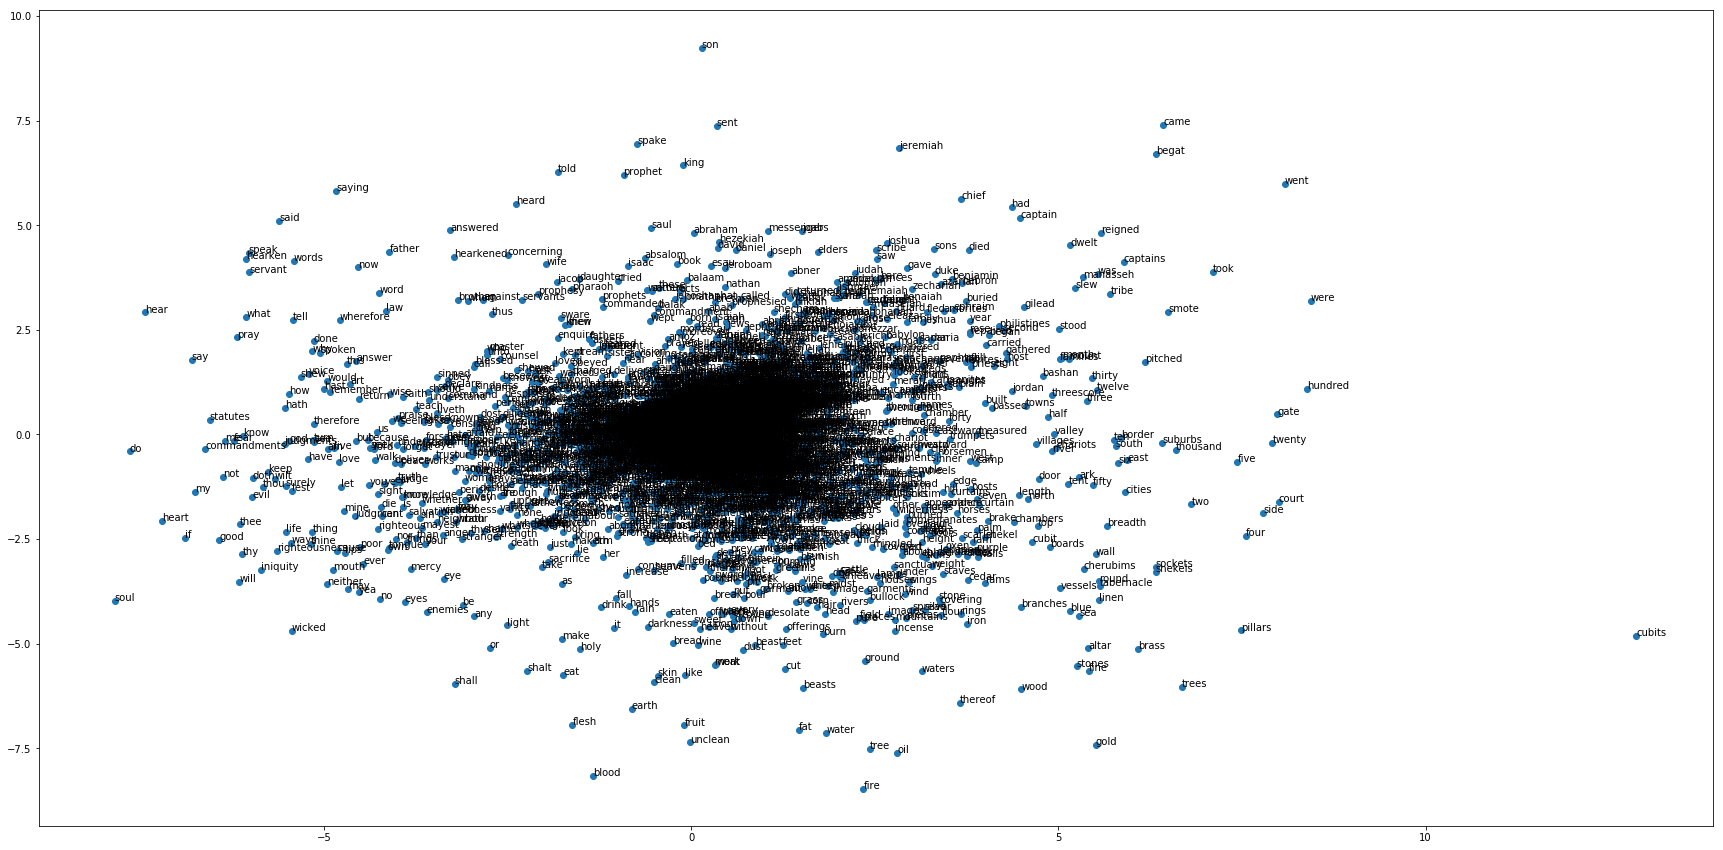

In [42]:
# create a scatter plot of the projection
plt.scatter(old_t_result[:, 0], old_t_result[:, 1])
words = list(old_t_model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(old_t_result[i, 0], old_t_result[i, 1]))

In [30]:
plt.rcParams['figure.figsize'] = (30,15)
plt.show()

In [65]:
old_t_res = old_t_model.wv.most_similar (positive=word_sample)
old_t_res

[('forget', 0.709946870803833),
 ('delight', 0.7051590085029602),
 ('despise', 0.6743418574333191),
 ('remember', 0.6494892835617065),
 ('statutes', 0.644416332244873),
 ('comfort', 0.6221784949302673),
 ('judgments', 0.6197844743728638),
 ('forsake', 0.6155949234962463),
 ('commandments', 0.613497257232666),
 ('desire', 0.6032434701919556)]

In [133]:
print(get_res(old_t_res))

['loving', 'eve', 'laboureth', 'gathrimmon', 'malcham', 'shubael', 'condemneth', 'shuhamites', 'reu', 'keros']


## New Testament

In [17]:
new_t_model = gensim.models.Word2Vec(
        new_t_documents,
        size=hp["size"],
        window=hp["window"],
        min_count=hp["min_count"],
        workers=hp["workers"])

new_t_model.train(new_t_documents, total_examples=len(new_t_documents), epochs=10)

(1162275, 1762370)

In [70]:
new_t_res = new_t_model.wv.most_similar (positive=word_sample)
list(new_t_res)

[('commandments', 0.7525415420532227),
 ('fulfil', 0.7512457966804504),
 ('keep', 0.7509554028511047),
 ('honour', 0.7489016652107239),
 ('work', 0.7439814209938049),
 ('forgive', 0.7391961812973022),
 ('patience', 0.7361048460006714),
 ('mind', 0.735201358795166),
 ('ceasing', 0.7329396605491638),
 ('serve', 0.7311650514602661)]

In [135]:
print(get_res(new_t_res))

['testament', 'ripe', 'less', 'invisible', 'elect', 'last', 'sown', 'mystery', 'adam', 'theirs']


# Quran

In [18]:
# NEW TESTAMENT
quran_model = gensim.models.Word2Vec(
        quran_documents,
        size=hp["size"],
        window=hp["window"],
        min_count=hp["min_count"],
        workers=hp["workers"])

quran_model.train(quran_documents, total_examples=len(quran_documents), epochs=10)

(1093947, 1682410)

In [68]:
quran_res = quran_model.wv.most_similar (positive=word_sample)
list(quran_res)

[('restraint', 0.7924559712409973),
 ('need', 0.7868920564651489),
 ('perish', 0.7677884101867676),
 ('practise', 0.754035234451294),
 ('behests', 0.7521225810050964),
 ('orphans', 0.751475989818573),
 ('prosper', 0.7510851621627808),
 ('deed', 0.7505643963813782),
 ('obey', 0.7415012121200562),
 ('loveth', 0.7355168461799622)]

In [144]:
print(get_res(quran_res))

['writing', 'maintenance', 'support', 'flog', 'bond', 'middle', 'lower', 'ties', 'silver', 'impure']


## Getting funky
Let's do some algebra...

In [159]:
# most_similar_cosmul
# most_similar

In [54]:
old_t_model.wv.most_similar_cosmul(positive=['god'], negative=['love'])

[('jordan', 1.9959980249404907),
 ('damascus', 1.9618990421295166),
 ('gibeon', 1.9448704719543457),
 ('mountain', 1.8508784770965576),
 ('hamath', 1.8297865390777588),
 ('camp', 1.8252360820770264),
 ('bethel', 1.8233864307403564),
 ('plain', 1.823033094406128),
 ('conduit', 1.8153852224349976),
 ('fattest', 1.7829551696777344)]

In [55]:
new_t_model.wv.most_similar_cosmul(positive=['god'], negative=['love'])

[('admonished', 1.8122432231903076),
 ('quarters', 1.7495546340942383),
 ('tiberias', 1.7476332187652588),
 ('taxing', 1.6462384462356567),
 ('the', 1.5816975831985474),
 ('beast', 1.5727702379226685),
 ('sea', 1.4993985891342163),
 ('ephesians', 1.4843356609344482),
 ('book', 1.4786556959152222),
 ('eventide', 1.4746479988098145)]

In [58]:
quran_model.wv.most_similar_cosmul(positive=['god'], negative=['woman'])

[('respond', 1.706364393234253),
 ('maker', 1.6665223836898804),
 ('all', 1.5843510627746582),
 ('glory', 1.5696157217025757),
 ('know', 1.563482642173767),
 ('ascribe', 1.5562021732330322),
 ('praise', 1.552486538887024),
 ('call', 1.538413643836975),
 ('partners', 1.521668791770935),
 ('knoweth', 1.5176702737808228)]

## How can we make this more accurate interesting?

One way is to, instead of relying purely on the text and word similarities, is create a topic model and base the VSM off of that. Based on an input word, determine the topic it is most liklely to fall under, and then show back the most relevant topics. Also converting all words and input into their lemmas to avoid grammatical issues.

Next steps:
1. 

## Data formatting and export
Create a list of sample words and export a csv of their context for each.

In [171]:
# Create a JSON file of all of the data!
# These are just most similar words.
# Can also create a file of sample algebra.
de = {}
test_words = ["peace","man","woman","child","love","hate","war","marriage"]
for w in test_words:
    de[w] = {}
    de[w]["old_t"] = old_t_model.wv.most_similar (positive=w)
    de[w]["new_t"] = new_t_model.wv.most_similar (positive=w)
    de[w]["quran"] = quran_model.wv.most_similar (positive=w)

In [172]:
de

{'child': {'new_t': [('haste', 0.7561442852020264),
   ('napkin', 0.7439369559288025),
   ('damsel', 0.7335579991340637),
   ('lifted', 0.7298068404197693),
   ('charger', 0.7209768891334534),
   ('looked', 0.7202779054641724),
   ('receipt', 0.7172028422355652),
   ('philip', 0.7126420736312866),
   ('trembling', 0.7096721529960632),
   ('saul', 0.7041950225830078)],
  'old_t': [('woman', 0.7549619078636169),
   ('damsel', 0.7061505317687988),
   ('husband', 0.6856222152709961),
   ('reapers', 0.6712771058082581),
   ('she', 0.6696698665618896),
   ('rebekah', 0.6502548456192017),
   ('tamar', 0.646457314491272),
   ('dead', 0.6433014869689941),
   ('amnon', 0.6334642171859741),
   ('naomi', 0.6255475282669067)],
  'quran': [('sister', 0.8970965147018433),
   ('husband', 0.8916230201721191),
   ('weaning', 0.8584035038948059),
   ('babe', 0.8578667044639587),
   ('aloud', 0.8519386649131775),
   ('re', 0.8485289812088013),
   ('heir', 0.8365462422370911),
   ('leaving', 0.828000426292

In [143]:
with open('test_result_1.json', 'w') as fp:
    json.dump(de, fp)